Tutorials
=========

Use functions with typed signatures
-----------------------------------

In order to "magically" create a Gui for the function parameters, Fiatlight needs to know the types of the parameters and the return value of the function. This is done by looking at the type hints in the function signature.

In the example below, `math.sin` and `math.cos` are unfortunately not typed. As a result:
* it is impossible to enter a value for the input parameter of the function `math.cos`
* the function `math.sin`, however works correctly in the graph, since it receives an input from float_source
  (and thus, it does not require an edition widget

**Wrap untyped functions that you wish to use**

Creating a wrapper for `math.cos` is extremely simple, and is shown by the `my_cos` function below. This function is typed, and Fiatlight can infer the widgets in the GUI. With this wrapper, we can also specify the range of acceptable values for numeric parameters.

**Code**

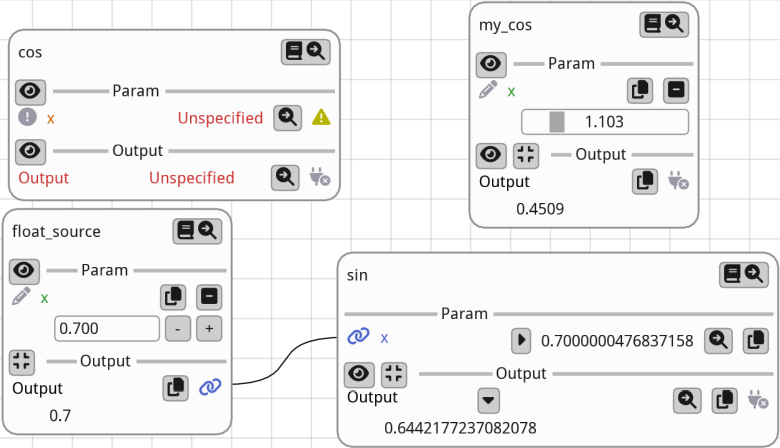

In [3]:
import math
import fiatlight as fl


def float_source(x: float) -> float:
    """A float source, where the user can specify the value of x."""
    return x


@fl.with_fiat_attributes(x__range=(0, 2 * math.pi))
def my_cos(x: float) -> float:
    """A wrapper around math.cos that adds types,
    so that Fiatlight can infer the widgets in the GUI."""
    return math.cos(x)


# We create a graph of functions, to which we will add functions manually
graph = fl.FunctionsGraph()

# Add a node that will run math.cos
# (Since this function has no type information,
# Fiatlight will not be able to infer the widgets in the GUI)
graph.add_function(math.cos)

# Add a node that will run my_cos
# (Since this function has type information,
# Fiatlight will be able to infer the widgets in the GUI)
graph.add_function(my_cos)

# Add a function composition that will transfer the output of float_source to math.sin
# (in this case, math.sin will work correctly, since it only has to display the numerical result,
# and does not require an edition widget)
graph.add_function_composition([float_source, math.sin])

# Run the graph
fl.run(graph, app_name="Typed Signatures")

Wrap native functions
---------------------

Native function, such as OpenCV functions, are often untyped (OpenCV is a C++ library that provide image processing functions).

If you wish to use them within Fiatlight, you will need to "wrap" them in a typed function.

**Example with OpenCV Canny edge detection**

In this example, we will create a wrapper for the OpenCV function `cv2.Canny`. This function detects edges in an image using the Canny algorithm. Its signature is a bit complex, and it has "gotchas": for example, the aperture size should be odd, between 3 and 7.

Below is an extract from the documentation for cv2.Canny:

> *C++*
>
>     void cv::Canny(InputArray image,
>        OutputArray edges,
>        float      threshold1,
>        float      threshold2,
>        int      apertureSize = 3,
>        bool      L2gradient = false);
>
> *Python*
>
>        cv2.Canny(dx, dy, threshold1, threshold2[, edges[, L2gradient]]) -> edges
>
> Parameters
>    * image: 8-bit input image.
>    * threshold1: first threshold for the hysteresis procedure.
>    * threshold2: second threshold for the hysteresis procedure.
>    * apertureSize: aperture size for the Sobel operator (should be odd, between 3 and 7).
>    * L2gradient: a flag, indicating whether a more accurate norm should be used to calculate the gradient
>
> Output:
>
>    * edges: output edge map; single channels 8-bit image, which has the same size as image .

The wrapper provided below is a bit more complex, since it wants to make it easy for the user to enter correct values for the aperture size (it uses an enum to specify the possible values).

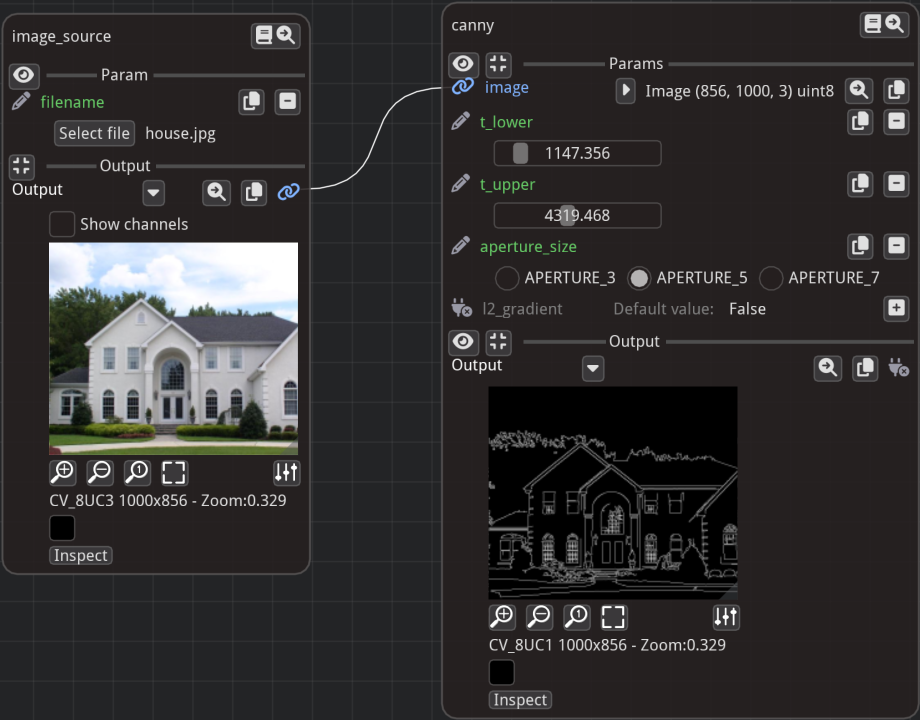

In [3]:
import fiatlight as fl
from fiatlight.fiat_types import ImagePath
import cv2
from enum import Enum

# Import types from Fiatlight: those are synonyms for numpy arrays,
# but they will be displayed as images in the GUI
#   (note: we could have used ImageU8 everywhere, because the image widet
#    is able to infer the type of the image from the numpy array)
from fiatlight.fiat_kits.fiat_image import ImageU8, ImageU8_GRAY


class CannyApertureSize(Enum):
    """Since the doc mentions that the aperture size should be odd, between 3 and 7
    the only possible values are 3, 5, and 7.
    This enum will make it easier to select the aperture size in the GUI.
    """
    APERTURE_3 = 3
    APERTURE_5 = 5
    APERTURE_7 = 7


# This is our wrapper for cv2.Canny
# - it uses the @fl.with_fiat_attributes decorator to specify the range of values for the input parameters
# - it uses the enum CannyApertureSize to specify the aperture size
# - it specifies that it accepts and outputs images
@fl.with_fiat_attributes(t_lower__range=(0, 10000), t_upper__range=(0, 10000))
def canny(
        image: ImageU8,  #
        t_lower: float,
        t_upper: float,
        aperture_size: CannyApertureSize = CannyApertureSize.APERTURE_3,
        l2_gradient: bool = False,
) -> ImageU8_GRAY:
    """
    :param image: Image: Input image to which Canny filter will be applied
    :param t_lower: T_lower: Lower threshold value in Hysteresis Thresholding
    :param t_upper: Upper threshold value in Hysteresis Thresholding
    :param aperture_size: Aperture size of the Sobel filter.
    :param l2_gradient   Boolean parameter used for more precision in calculating Edge Gradient.
    :return: a binary image with edges detected using Canny filter
    """
    r = cv2.Canny(image, t_lower, t_upper, apertureSize=aperture_size.value, L2gradient=l2_gradient)
    return r  # type: ignore


# Let's see our wrapper in action
def image_source(filename: ImagePath) -> ImageU8:
    """A source of images"""
    return cv2.imread(filename)


# Run the application
fl.run([image_source, canny], app_name="Canny Edge Detection")